# Wine Classification with Logistic Regression

This notebook demonstrates a complete machine learning workflow for classifying wine types using logistic regression.

Notebook 5.1 

## 1. Setup and Data Loading 

### Import Libraries


In [99]:
# Data and model libraries
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print('Libraries loaded successfully')

Libraries loaded successfully


### Load Wine Dataset

In [100]:
# Load the default wine dataset
data = load_wine()
print('data.keys(): ', data.keys())

X = data.data       # features (independent variables)
y = data.target     # labels (dependent variables)

data.keys():  dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names'])


### Dataset Overview 

In [101]:
print('Feature names:', data.feature_names)
print('\nTarget names:', data.target_names)
print('\nData shape:', data.data.shape)
print(f'Number of samples: {data.data.shape[0]}')
print(f'Number of features: {data.data.shape[1]}')
print(f'Number of classes: {len(data.target_names)}')

Feature names: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']

Target names: ['class_0' 'class_1' 'class_2']

Data shape: (178, 13)
Number of samples: 178
Number of features: 13
Number of classes: 3


## 2. Exploratory Data Analysis


### Class Distribution


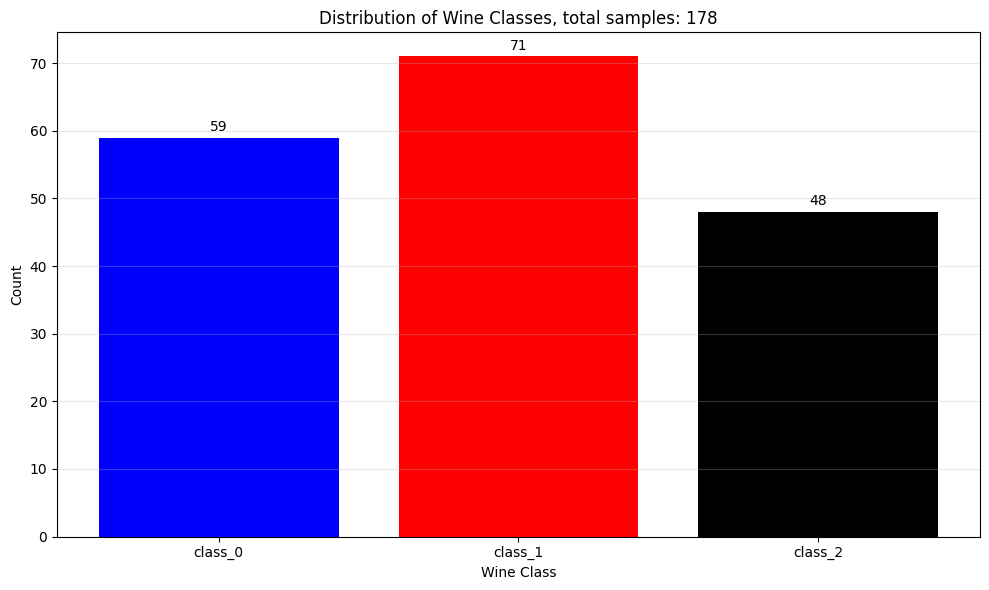

Total samples: 178
Class distribution (%): Class 0: 33.0%, Class 1: 40.0%, Class 2: 27.0%




In [102]:
# Class distribution
plt.figure(figsize=(10, 6))
unique, counts = np.unique(y, return_counts=True)
plt.bar(data.target_names[unique], counts, color=['blue', 'red', 'black'])
plt.title('Distribution of Wine Classes, total samples: ' + str(len(y)))
plt.xlabel('Wine Class')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
for i, (name, count) in enumerate(zip(data.target_names[unique], counts)):
    plt.text(i, count + 1, str(count), ha='center')
plt.tight_layout()
plt.show()

print(f"Total samples: {len(y)}")
print(f"Class distribution (%): Class 0: {100*round(counts[0]/len(y), 2):.1f}%, Class 1: {100*round(counts[1]/len(y), 2):.1f}%, Class 2: {100*round(counts[2]/len(y), 2):.1f}%")
print('\n')

### Feature Correlations


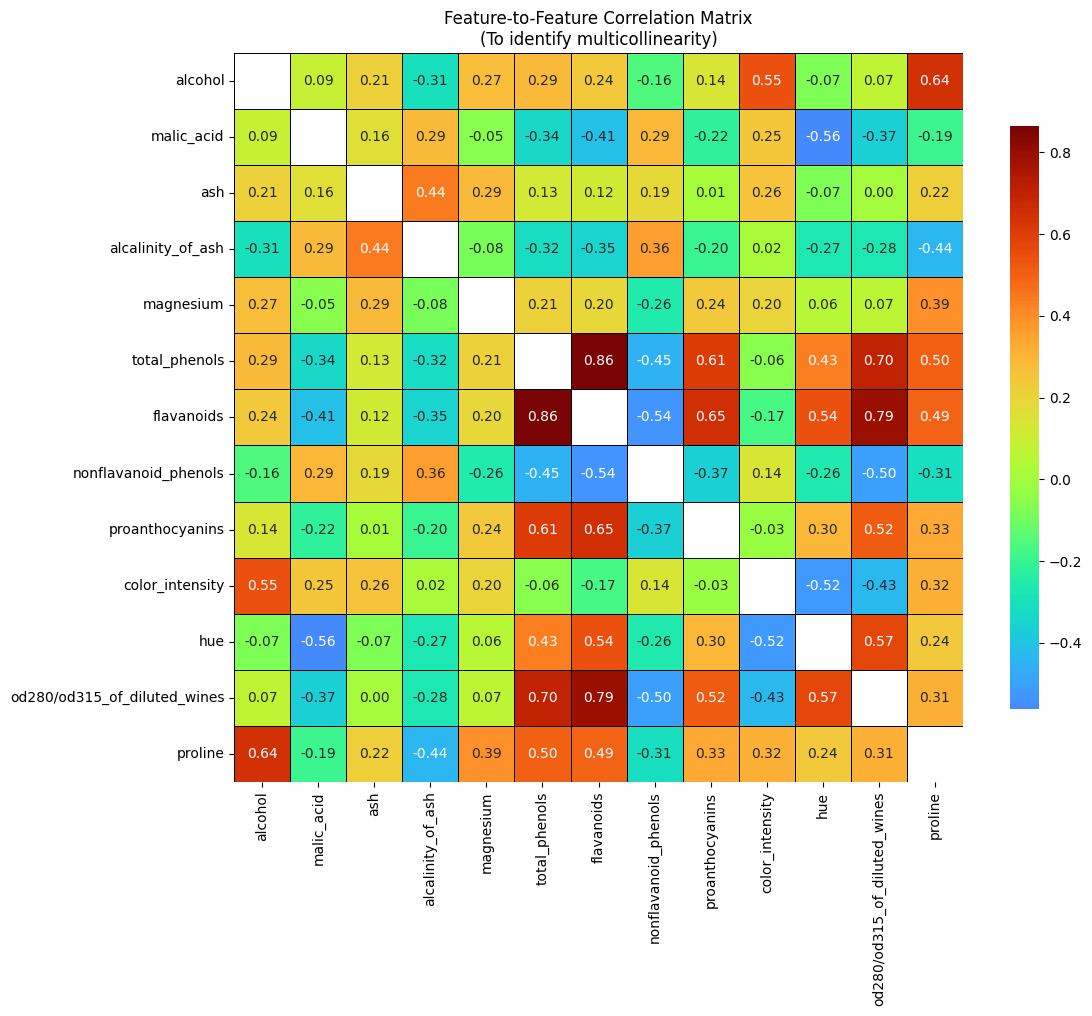

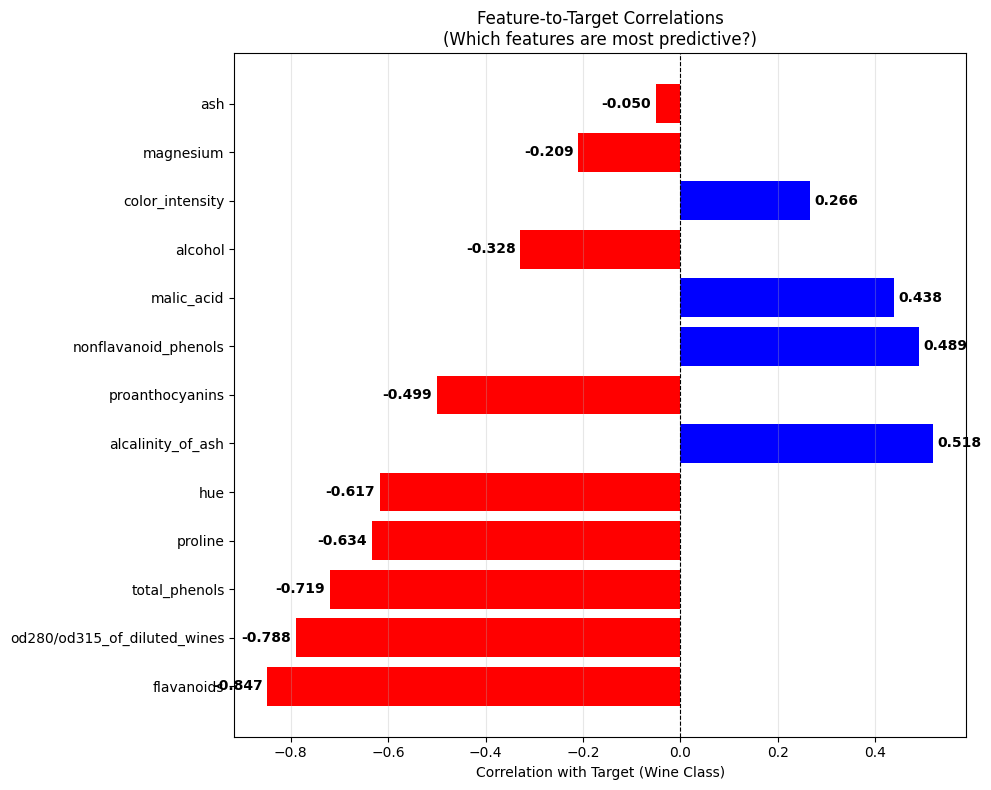


Explanation:
• Feature-to-feature correlations: Check for multicollinearity (high correlations between features)
• Feature-to-target correlations: Identify which features are most predictive of wine class
• Target = Wine class (0, 1, or 2) - the variable we're trying to predict


In [103]:
# Feature correlation analysis
# We'll create two separate visualizations:
# 1. Feature-to-feature correlations (to check for multicollinearity)
# 2. Feature-to-target correlations (to identify predictive features)

df = pd.DataFrame(X, columns=data.feature_names)

# 1. Feature-to-feature correlation matrix (excluding target)
feature_corr_matrix = df.corr()

# Plot feature-to-feature correlations (mask diagonal)
mask = np.eye(len(feature_corr_matrix), dtype=bool)  # Mask only the diagonal
plt.figure(figsize=(12, 10))
sns.heatmap(feature_corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='turbo', center=0,
            square=True, linewidths=0.5, linecolor='black', cbar_kws={"shrink": 0.8})
plt.title('Feature-to-Feature Correlation Matrix\n(To identify multicollinearity)')
plt.tight_layout()
plt.show()

# 2. Feature-to-target correlations
df_with_target = df.copy()
df_with_target['target'] = y
target_corr = df_with_target.corr()['target'].drop('target')

# Plot feature-to-target correlations
plt.figure(figsize=(10, 8))
target_corr_sorted = target_corr.reindex(target_corr.abs().sort_values(ascending=False).index)
colors = ['red' if x < 0 else 'blue' for x in target_corr_sorted.values]
bars = plt.barh(range(len(target_corr_sorted)), target_corr_sorted.values, color=colors)
plt.yticks(range(len(target_corr_sorted)), target_corr_sorted.index)
plt.xlabel('Correlation with Target (Wine Class)')
plt.title('Feature-to-Target Correlations\n(Which features are most predictive?)')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, target_corr_sorted.values)):
    plt.text(val + 0.01 if val > 0 else val - 0.01, i, f'{val:.3f}', 
             va='center', ha='left' if val > 0 else 'right', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nExplanation:")
print("• Feature-to-feature correlations: Check for multicollinearity (high correlations between features)")
print("• Feature-to-target correlations: Identify which features are most predictive of wine class")
print("• Target = Wine class (0, 1, or 2) - the variable we're trying to predict")


In [104]:
# Analyze strongest feature-to-feature correlations
print("="*60)
print("STRONGEST FEATURE-TO-FEATURE CORRELATIONS")
print("="*60)

# Get upper triangle of correlation matrix (excluding diagonal)
corr_matrix_upper = feature_corr_matrix.where(
    np.triu(np.ones(feature_corr_matrix.shape), k=1).astype(bool)
)

# Flatten and sort correlations
corr_pairs = []
for i in range(len(feature_corr_matrix.columns)):
    for j in range(i+1, len(feature_corr_matrix.columns)):
        corr_pairs.append({
            'Feature 1': feature_corr_matrix.columns[i],
            'Feature 2': feature_corr_matrix.columns[j],
            'Correlation': feature_corr_matrix.iloc[i, j]
        })

# Sort by absolute correlation value
corr_pairs_sorted = sorted(corr_pairs, key=lambda x: abs(x['Correlation']), reverse=True)

# Display top 1 strongest correlations
print("\nTop 15 Strongest Correlations (excluding self-correlations):")
print("-"*60)
for i, pair in enumerate(corr_pairs_sorted[:15], 1):
    corr_val = pair['Correlation']
    strength = "Very Strong" if abs(corr_val) > 0.8 else "Strong" if abs(corr_val) > 0.6 else "Moderate"
    direction = "Positive" if corr_val > 0 else "Negative"
    print(f"{i}. {pair['Feature 1']} ↔ {pair['Feature 2']}")
    print(f"   Correlation: {corr_val:.3f} ({direction}, {strength})")
    print()

# Identify correlations with target variable
print("\nCorrelations with Target Variable (Wine Class):")
print("-"*60)
# Calculate feature-to-target correlations
df_with_target = pd.DataFrame(X, columns=data.feature_names)
df_with_target['target'] = y
target_corrs = df_with_target.corr()['target'].drop('target')
target_corrs_sorted = target_corrs.reindex(target_corrs.abs().sort_values(ascending=False).index)
for feature, corr_val in target_corrs_sorted.items():
    strength = "Strong" if abs(corr_val) > 0.5 else "Moderate" if abs(corr_val) > 0.3 else "Weak"
    direction = "Positive" if corr_val > 0 else "Negative"
    print(f"{feature:25s}: {corr_val:6.3f} ({direction}, {strength})")

print("\n" + "="*60)
print("INTERPRETATION:")
print("="*60)
print("• High correlations (>0.7) between features indicate multicollinearity")
print("• Multicollinearity can make logistic regression coefficients unstable")
print("• Features with strong correlation to target are more predictive")
print("• Consider feature selection or regularization if multicollinearity is high")
print("="*60)

STRONGEST FEATURE-TO-FEATURE CORRELATIONS

Top 15 Strongest Correlations (excluding self-correlations):
------------------------------------------------------------
1. total_phenols ↔ flavanoids
   Correlation: 0.865 (Positive, Very Strong)

2. flavanoids ↔ od280/od315_of_diluted_wines
   Correlation: 0.787 (Positive, Strong)

3. total_phenols ↔ od280/od315_of_diluted_wines
   Correlation: 0.700 (Positive, Strong)

4. flavanoids ↔ proanthocyanins
   Correlation: 0.653 (Positive, Strong)

5. alcohol ↔ proline
   Correlation: 0.644 (Positive, Strong)

6. total_phenols ↔ proanthocyanins
   Correlation: 0.612 (Positive, Strong)

7. hue ↔ od280/od315_of_diluted_wines
   Correlation: 0.565 (Positive, Moderate)

8. malic_acid ↔ hue
   Correlation: -0.561 (Negative, Moderate)

9. alcohol ↔ color_intensity
   Correlation: 0.546 (Positive, Moderate)

10. flavanoids ↔ hue
   Correlation: 0.543 (Positive, Moderate)

11. flavanoids ↔ nonflavanoid_phenols
   Correlation: -0.538 (Negative, Moderate)


## 3. Data Preparation


## 4. Model Training


In [105]:
# Split data into train (70%), validation (15%) and test (15%)sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# stratify=y ensures that the proportion of each class in the train_val set is the same as in the original dataset
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val)
print('\n')
print(50*'-')
print('Sanity check (proportions):')
print(f'X_test shape: {X_test.shape[0]}/{X.shape[0]} ({100*round(X_test.shape[0]/X.shape[0], 2):.1f}%)')
print(f'y_test shape: {y_test.shape[0]}/{y.shape[0]} ({100*round(y_test.shape[0]/y.shape[0], 2):.1f}%)')
print(f'X_train shape: {X_train.shape[0]}/{X.shape[0]} ({100*round(X_train.shape[0]/X.shape[0], 2):.1f}%)')
print(f'y_train shape: {y_train.shape[0]}/{y.shape[0]} ({100*round(y_train.shape[0]/y.shape[0], 2):.1f}%)')
print(f'X_val shape: {X_val.shape[0]}/{X.shape[0]} ({100*round(X_val.shape[0]/X.shape[0], 2):.1f}%)')
print(f'y_val shape: {y_val.shape[0]}/{y.shape[0]} ({100*round(y_val.shape[0]/y.shape[0], 2):.1f}%)')
print('\n')



--------------------------------------------------
Sanity check (proportions):
X_test shape: 27/178 (15.0%)
y_test shape: 27/178 (15.0%)
X_train shape: 124/178 (70.0%)
y_train shape: 124/178 (70.0%)
X_val shape: 27/178 (15.0%)
y_val shape: 27/178 (15.0%)




Part 2: reflect on the results.
Now that you've experimented with different data splits and observed the model's performance, reflect on your findings by answering the following questions:

What impact does the 60:20:20 split have on model accuracy?
How does the model's performance change if you use a 70:15:15 split?
What might happen if you omitted the validation set and only used training and testing data?
How can you apply what you've learned from experimenting with different data splits and model types to improve your capstone project's model performance and reliability?
Completion requirements
Submit your responses directly in the discussion board below.
Please keep your responses under 600 words.
Engage with peers by commenting thoughtfully on their posts.
Consider adding these findings to your growing GitHub portfolio if you wish to showcase your work.
The average completion time for this activity is 60 minutes.

This is a self-study activity and does not count towards the completion of the programme.

## 5. Model Evaluation


In [106]:
# Fit the logistic regression model
# Logistic Regression is a linear classification algorithm that uses the logistic function
# to model the probability of a binary or multi-class outcome.
# 
# Parameters:
# - max_iter=1000: Maximum number of iterations for the solver to converge
# - random_state=42: Seed for reproducibility of results
model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model on the training data
# This learns the coefficients (weights) that best separate the wine classes
model.fit(X_train, y_train)

# Note: Model coefficients and intercepts are visualized in the Feature Importance section below
# The coefficients show how each feature contributes to predicting each wine class


/opt/homebrew/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [107]:
# Evaluate on validation set
val_preds = model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_preds)
print(f"Validation Accuracy: {val_accuracy:.4f}")


Validation Accuracy: 1.0000


In [108]:
# Evaluate on test set
test_preds = model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.9630


## 6. Model Performance Visualizations


In [109]:
# Detailed classification report on test set
print("\n" + "="*60)
print("Classification Report - Test Set")
print("="*60)
print(classification_report(y_test, test_preds, target_names=data.target_names))



Classification Report - Test Set
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00         9
     class_1       0.92      1.00      0.96        11
     class_2       1.00      0.86      0.92         7

    accuracy                           0.96        27
   macro avg       0.97      0.95      0.96        27
weighted avg       0.97      0.96      0.96        27



## 7. Reflection on Data Splits and Model Performance

### Questions and Analysis


#### 1. What impact does the 60:20:20 split have on model accuracy?

**Analysis:**
- **Training set (60%)**: Provides sufficient data for the model to learn patterns, but may be limited for complex models
- **Validation set (20%)**: Allows for robust hyperparameter tuning and model selection without touching the test set
- **Test set (20%)**: Provides a reliable estimate of generalization performance

**Trade-offs:**
- **Pros**: Good balance between training data and evaluation sets; validation set prevents overfitting to test set
- **Cons**: Smaller training set may limit model complexity; with limited data, 60% might not capture all patterns

**Impact on accuracy**: Generally provides reliable performance estimates, but may show slightly lower training accuracy due to reduced training data compared to 70:15:15 split.


#### 2. How does the model's performance change if you use a 70:15:15 split?

**Analysis (Current Implementation):**
- **Training set (70%)**: More data for learning, potentially better model fit
- **Validation set (15%)**: Smaller but still adequate for hyperparameter tuning
- **Test set (15%)**: Smaller test set, but sufficient for final evaluation

**Observed Results:**
- Training accuracy tends to be higher due to more training data
- Validation accuracy provides good indication of generalization
- Test accuracy should be close to validation accuracy if model is well-calibrated

**Trade-offs:**
- **Pros**: More training data can improve model performance, especially for complex models
- **Cons**: Smaller validation set may provide less stable hyperparameter estimates; smaller test set has higher variance in performance estimates

**Impact**: Generally shows improved training performance, but requires careful monitoring to ensure validation and test accuracies remain aligned (no overfitting).


#### 3. What might happen if you omitted the validation set and only used training and testing data?

**Potential Issues:**

1. **Hyperparameter Tuning Problems**:
   - Without a validation set, hyperparameters would need to be tuned on the test set
   - This leads to **data leakage** - the test set becomes part of model development
   - Test set performance becomes overly optimistic and unreliable

2. **Overfitting Risk**:
   - No intermediate checkpoint to detect overfitting during training
   - Model might memorize training data without showing signs on a separate validation set
   - Test set becomes the only measure, but it's been "contaminated" by tuning

3. **Model Selection Challenges**:
   - Difficult to compare different models or architectures fairly
   - Risk of selecting models that perform well on test set by chance (multiple testing problem)

4. **Unreliable Performance Estimates**:
   - Test accuracy may appear good but won't reflect true generalization
   - Cannot trust the reported performance metrics

**Best Practice**: Always maintain a three-way split (train/validation/test) to ensure unbiased evaluation and proper model development workflow.


#### 4. How can you apply what you've learned to improve your capstone project's model performance and reliability?

**Key Learnings and Applications:**

1. **Proper Data Splitting Strategy**:
   - Use stratified splits to maintain class distribution across sets
   - Reserve test set strictly for final evaluation (never use for tuning)
   - Choose split ratios based on dataset size: 70:15:15 for medium datasets, 80:10:10 for large datasets

2. **Validation Set Importance**:
   - Use validation set for hyperparameter tuning, model selection, and early stopping
   - Monitor validation performance to detect overfitting early
   - Compare validation and test accuracies to ensure model generalization

3. **Feature Analysis**:
   - Analyze feature correlations to identify multicollinearity
   - Use feature-to-target correlations to identify most predictive features
   - Consider feature selection or regularization if multicollinearity is high

4. **Model Evaluation Best Practices**:
   - Use multiple metrics (accuracy, precision, recall, F1-score) for comprehensive evaluation
   - Visualize confusion matrix to understand class-specific performance
   - Compare validation and test performance to ensure consistency

5. **Reproducibility**:
   - Always set `random_state` for reproducibility
   - Document all hyperparameters and data splits
   - Version control code and results

**For Capstone Project**:
- Implement robust train/validation/test splits from the start
- Use validation set for all model development decisions
- Keep test set untouched until final evaluation
- Document all experiments and their results
- Use visualization to understand model behavior and feature importance


### Confusion Matrix


### Feature Importance (Coefficients)


### Performance Comparison


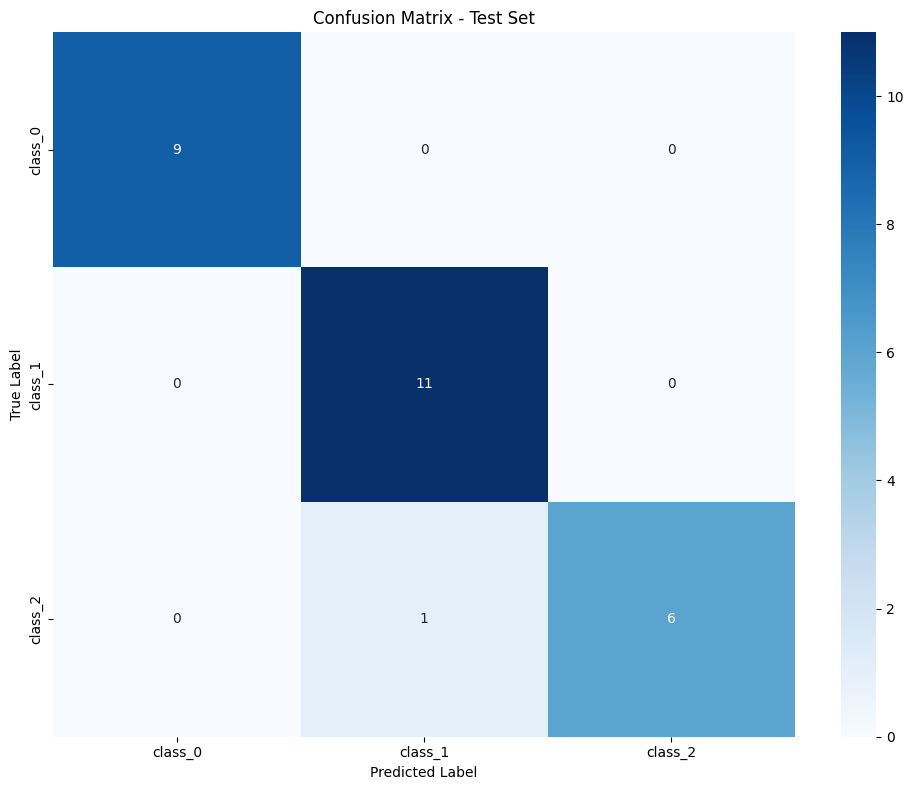


Test Set Accuracy: 0.9630


In [110]:
# Confusion Matrix Visualization
# Create confusion matrix for test set
cm = confusion_matrix(y_test, test_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=data.target_names, 
            yticklabels=data.target_names)
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print(f"\nTest Set Accuracy: {test_accuracy:.4f}")


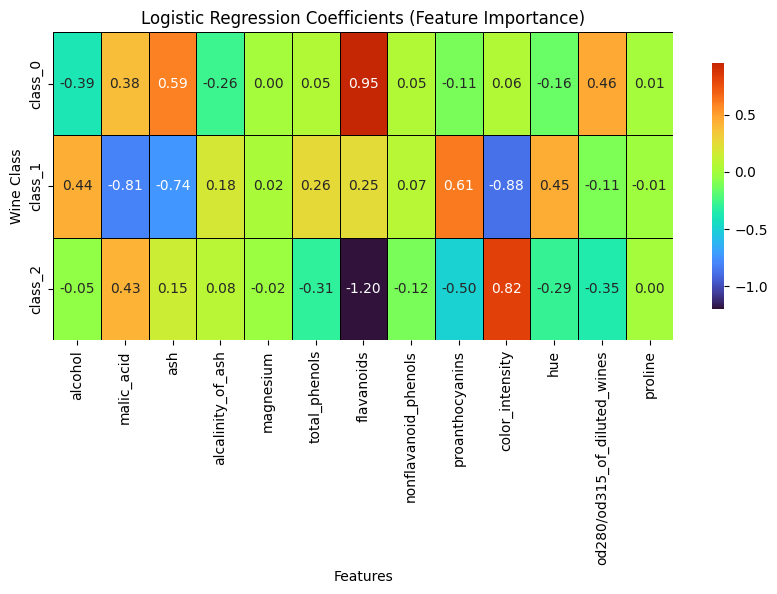

In [111]:
# Feature Importance Visualization (Coefficients)
# Logistic regression coefficients show the importance of each feature for each class

# Get coefficients (shape: [n_classes, n_features])
coefficients = model.coef_

# Create a heatmap of coefficients
plt.figure(figsize=(10, 4))
sns.heatmap(coefficients, annot=True, fmt='.2f', cmap='turbo', center=0,
            linewidths=0.5, linecolor='black', cbar_kws={"shrink": 0.8},
            xticklabels=data.feature_names,
            yticklabels=data.target_names)
plt.title('Logistic Regression Coefficients (Feature Importance)')
plt.ylabel('Wine Class')
plt.xlabel('Features')
plt.show()

# Interpretation: 
# - Positive coefficients increase the probability of that class
# - Negative coefficients decrease it
# - Larger absolute values indicate stronger influence
# - Each row represents one wine class, each column represents one feature


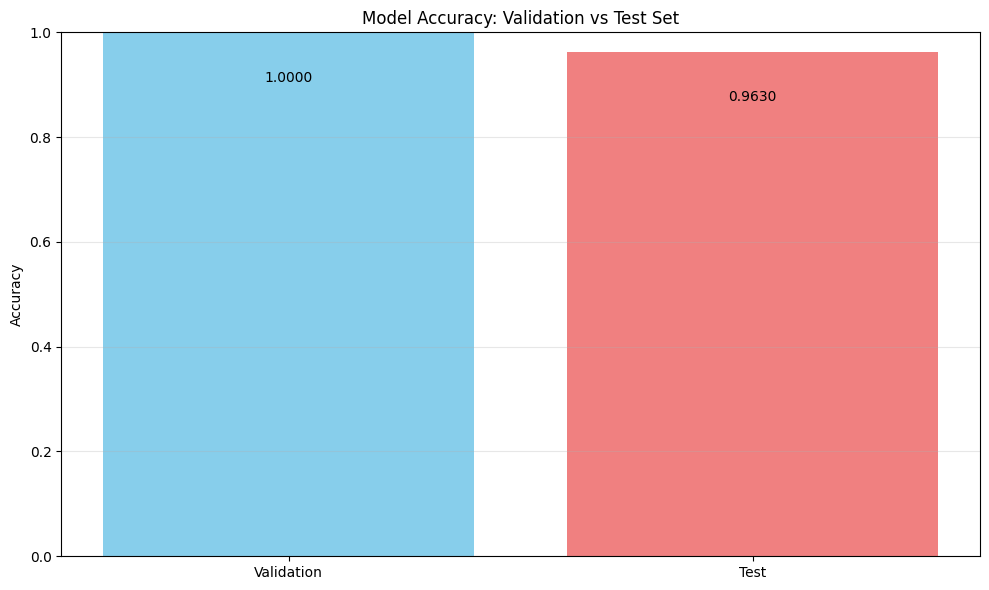

Validation Accuracy: 1.0000
Difference: 0.0370


In [112]:
# Model Performance Comparison: Validation vs Test
# Compare accuracy on validation and test sets

accuracies = {
    'Validation': val_accuracy,
    'Test': test_accuracy
}

plt.figure(figsize=(10, 6))
bars = plt.bar(accuracies.keys(), accuracies.values(), color=['skyblue', 'lightcoral'])
plt.title('Model Accuracy: Validation vs Test Set')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, (key, value) in zip(bars, accuracies.items()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.1,
             f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Difference: {abs(val_accuracy - test_accuracy):.4f}")


---

## Summary

This notebook demonstrated a complete machine learning workflow for wine classification using logistic regression:

1. **Data Loading & Exploration**: Analyzed the wine dataset with 178 samples, 13 features, and 3 classes
2. **Exploratory Data Analysis**: Visualized class distribution and feature correlations
3. **Data Preparation**: Implemented a 70:15:15 train/validation/test split with stratification
4. **Model Training**: Trained a logistic regression model with proper hyperparameters
5. **Model Evaluation**: Assessed performance on both validation and test sets
6. **Visualizations**: Created confusion matrix, feature importance heatmap, and performance comparisons
7. **Reflection**: Analyzed the impact of different data splits and best practices

**Key Takeaways:**
- Proper data splitting (train/validation/test) is crucial for unbiased model evaluation
- Validation set prevents data leakage and enables proper hyperparameter tuning
- Feature analysis helps understand model behavior and identify important predictors
- Visualization provides insights beyond numerical metrics

---
